In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyreadr

In [14]:
# Import data
raw_data = pyreadr.read_r("./Data/crosssecdata.RData")['datatax']
raw_data.head()

,otu_id,count,project_id,sample_id,run_id,nreads,classification
0,107380,7.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
1,149885,1.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
2,118090,6.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
3,103181,854.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
4,83222,1.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater


**project_id**: identifies projects\
**classification**: identifies the environments considered within a project\
**sample_id**: identifies samples (communities) gathered within the same environment\
**run_id**: identifies the machine run to identify species in a sample. Multiple runs are possible within the same sample\
**otu_id**: identifies species\
**count**: number of species with specific otu_id observed in a single run\
**nreads**: total number of species observed in a single run

In [15]:
# Some environments have 'nreads' and 'count' inverted (I suppose) so they need to be fixed
mask = raw_data['nreads'] < raw_data['count']
raw_data.loc[mask, ['nreads', 'count']] = raw_data.loc[mask, ['count', 'nreads']].values

In [16]:
# Further analysis is done only for environments with a 'sufficient' number of samples and
# for runs which detected a 'sufficient' number of reads (I don't know if the order of these operations is important)
min_samples = 50
min_nreads = 1e4
filtered_data = raw_data.groupby('project_id').filter(lambda x: x['sample_id'].nunique() > min_samples)
filtered_data = filtered_data[filtered_data['nreads'] > min_nreads]

In [17]:
# Divide data for different environments
SEAWATER = filtered_data[filtered_data['classification'] == ' seawater']
EAM = filtered_data[filtered_data['classification'] == 'Environmental Aquatic Marine']
EAMH = filtered_data[filtered_data['classification'] == 'Environmental Aquatic Marine Hydrothermal vents']
ETS = filtered_data[filtered_data['classification'] == 'Environmental Terrestrial Soil']
GUT = filtered_data[filtered_data['classification'] == 'GUT']
GLACIER = filtered_data[filtered_data['classification'] == 'Glacier']
LAKE = filtered_data[filtered_data['classification'] == 'Lake']
ORAL = filtered_data[filtered_data['classification'] == 'ORAL']
RIVER = filtered_data[filtered_data['classification'] == 'River']
VAGINAL = filtered_data[filtered_data['classification'] == 'VAGINAL']
SLUDGE = filtered_data[filtered_data['classification'] == 'activatedsludge']
FECES = filtered_data[filtered_data['classification'] == 'feces']
ORALCAVITY = filtered_data[filtered_data['classification'] == 'oralcavity']
SKIN = filtered_data[filtered_data['classification'] == 'skin']

# Drop 'classification' column and compute frequencies
dfs = [SEAWATER, EAM, EAMH, ETS, GUT, GLACIER, LAKE, ORAL,
       RIVER, VAGINAL, SLUDGE, FECES, ORALCAVITY, SKIN]

for i,df in enumerate(dfs):
    df = df.drop(columns=['classification'])
    df = df.copy()
    df['f'] = df['count'] / df['nreads']
    dfs[i] = df

# Extract all environments
# NOTE: Each environment can still have samples from different projects. Since I don't have any information about 
#       the specific methodologies used in different experiments, I treat them as statistically equivalent.
(SEAWATER, EAM, EAMH, ETS, GUT, GLACIER, LAKE, ORAL,
 RIVER, VAGINAL, SLUDGE, FECES, ORALCAVITY, SKIN) = dfs

In [29]:
# Restrinct further analysis to a specific environment
df = LAKE

# For each sample, consider the frequency as the mean across different runs
df['f'] = df.groupby(['otu_id', 'sample_id'])['f'].transform('mean')
# df = df[df['f'] > 0]
df['log_f'] = np.log(df['f'])
df = df.drop(columns=['run_id','count','nreads'])
df = df.drop_duplicates()

# Taylor's law

In [30]:
# Compute mean and variance across samples for each species
df_T = df.copy() # Work on a copy of the original df
df_T['mean_f'] = df_T.groupby(['otu_id'])['f'].transform('mean')
df_T['var_f'] = df_T.groupby(['otu_id'])['f'].transform('var')
df_T = df_T.drop(columns=['project_id','sample_id','f','log_f'])
df_T = df_T.drop_duplicates()
df_T = df_T.dropna()

In [40]:
# Bin the (log) frequencies and to avoid overcrowding the plot
means = np.log(np.array(df_T[df_T['mean_f'] > 1e-2]['mean_f']))
variances = np.array(df_T[df_T['mean_f'] > 1e-2]['var_f'])
counts, edges = np.histogram(means, bins=50)
bincenters = (edges[1:] + edges[:-1]) / 2
print(min(bincenters), min(means))

# The corresponding variance is the mean of the variances inside a bin
grouped_variances = []
for i in range(len(edges[:-1])):
    a, b = edges[i], edges[i+1]
    mask = (means >= a) & (means < b)
    if len(variances[mask]) > 0:
        g_var = np.mean(variances[mask])
        grouped_variances.append(g_var)
    else:
        grouped_variances.append(np.nan)

grouped_variances = np.array(grouped_variances)
bincenters = bincenters[~np.isnan(grouped_variances)]
grouped_variances = grouped_variances[~np.isnan(grouped_variances)]

# Fit to find the exponent of taylor's law
m, q = np.polyfit(np.log(grouped_variances), bincenters,  1)
alpha = 1/m
beta = np.exp(m*q)
print(f"Taylor's exponent: {alpha}, shape: {beta}")

-4.560441408448604 -4.578028204919134
Taylor's exponent: 2.343446896447649, shape: 0.8380920102884983


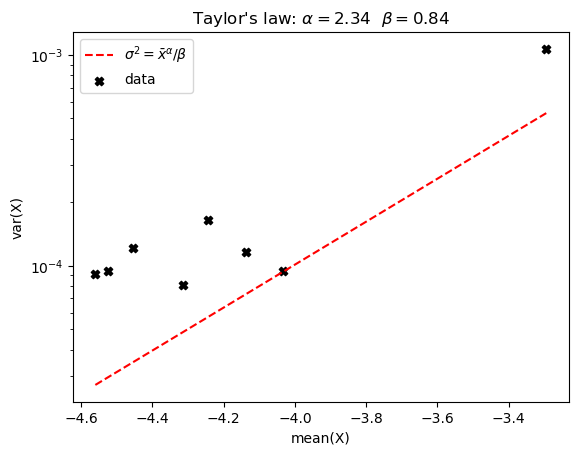

In [36]:
xrange = np.linspace(np.min(bincenters),np.max(bincenters),1000)
f = np.exp(alpha*xrange) / beta
plt.plot(xrange,f,c='r',ls='--',label=r'$\sigma^2 = \bar{x}^{\alpha} / \beta$')

plt.scatter(bincenters, grouped_variances, c='black',marker='X',label='data')
plt.yscale('log')
plt.xlabel('mean(X)')
plt.ylabel('var(X)')
plt.legend()
plt.title(rf"Taylor's law: $\alpha = {np.round(alpha,2)}$  $\beta = {np.round(beta,2)}$")
plt.savefig('./Images/Taylor_GUT.png')
plt.show()

# AFD

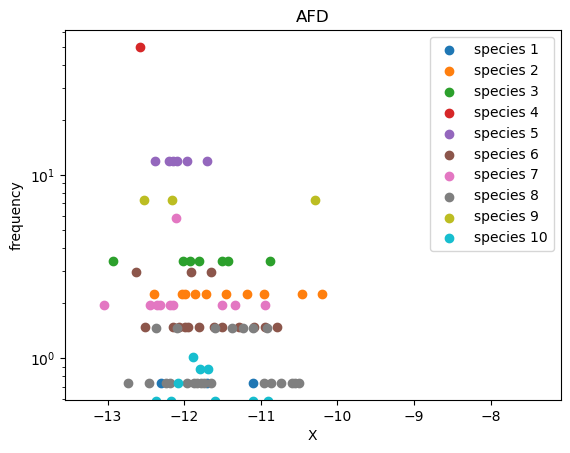

In [11]:
# Make normalized histogram
i = 0
for species in np.sort(np.unique(df['otu_id']))[::-1][:10]:
    log_f = df[df['otu_id'] == species]['r_mean_f']
    counts, edges = np.histogram(log_f, bins=50)
    counts = counts / np.sum(counts) / (edges[1] - edges[0])
    bin_centers = (edges[1:] + edges[:-1]) / 2

    # Compute mean and standard deviation from the histogram
    total_count = np.sum(counts)
    mean = np.sum(bin_centers * counts) / total_count
    variance = np.sum(((bin_centers - mean) ** 2) * counts) / total_count
    std_dev = np.sqrt(variance)

    # Rescale entries for comparison
    #if std_dev > 0.0:
    i += 1
        #bin_centers = (bin_centers - mean) / std_dev
    plt.scatter(bin_centers, counts, label=f'species {i}')

plt.title('AFD')
plt.xlabel('X')
plt.ylabel('frequency')
plt.yscale('log')
plt.legend()
plt.show()

# MAD

In [4]:
# set bin edges
n_bins = 20
bin_edges = np.linspace(np.log(proj['env_f'].min()), np.log(proj['env_f'].max()), n_bins)
delta = bin_edges[1] - bin_edges[0]

# Group by the specified columns
grouped = proj.groupby(['env_id'])

# Iterate through each group and compute the histogram
histograms = {}
for env, group in grouped:

    key = str(env)[12:-3]
    entries, bins = np.histogram(np.log(group['env_f']), bins=bin_edges)
    bins = bins.tolist()
    entries = entries.tolist()
    centers = np.array([(bins[i+1] + bins[i])/2 for i in range(len(bins) - 1)])
    frequencies = np.array(entries/np.sum(entries))/delta
    
    mu = np.sum(entries*centers)/np.sum(entries)
    std = np.sum(entries*(centers - mu)**2)/(np.sum(entries)-1)
    std = np.sqrt(np.abs(std))
    histograms[key] = {
        'bin_centers': centers,
        'frequencies': frequencies,
        'mean': mu,
        'std': std
    }

Frequencies should be lognormally distributed but since I made the histogram of the logarithms then I expect them to follow a normal distribution. Each environment follows its own normal distribution with parameters $\mu$ and $\sigma$ but with the substituion
$$x → \frac{x-\mu}{\sqrt{2\sigma^2}}$$
then the frequencies goes like
$$y = \frac{e^{-x^2}}{\sqrt{2\pi\sigma^2}}.$$\
We can rearrange and plot the y axis in logarithmic scale considering
$$\log{\left(\sqrt{2\pi\sigma^2}y\right)} = -x^2.$$


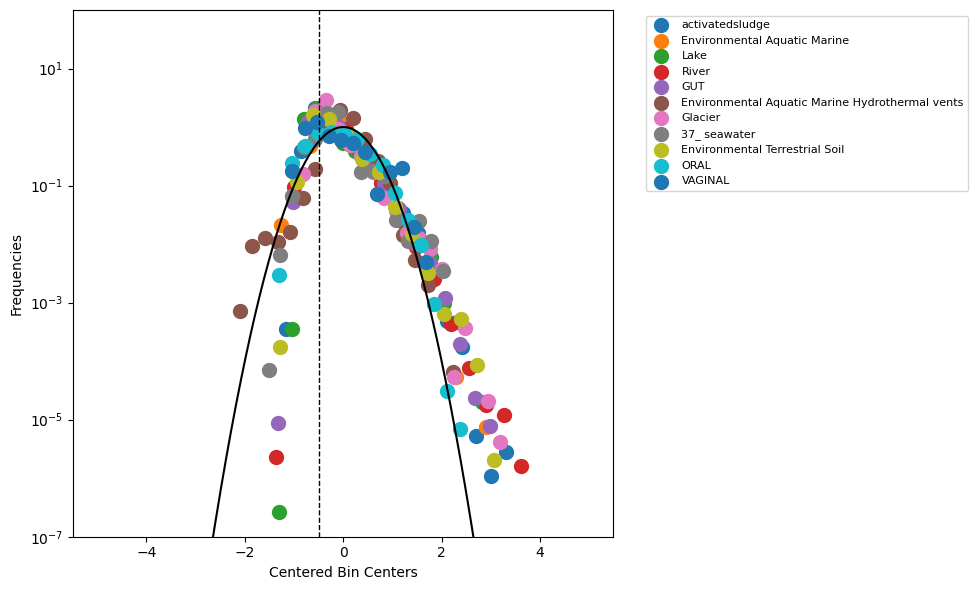

In [7]:
plt.figure(figsize=(10, 6))
    
x = np.arange(-5,5,0.01)
plt.plot(x, 10**(-x**2), c='black')

#bad_envs = ['37_ seawater','feces','skin','oralcavity','VAGINAL'] # these data are way off the expected distribution
bad_envs = []
keys = list(histograms.keys())
keys = [key for key in keys if key not in bad_envs]
mean_std = []
for key in keys:
    mask = histograms[key]['frequencies'] > 0 # mask to avoid problems when taking the logarithm
    mu = histograms[key]['mean']
    std = histograms[key]['std']
    x = (histograms[key]['bin_centers'][mask] - mu)/np.sqrt(2*std**2)
    y = 10**(np.log(histograms[key]['frequencies'][mask]*np.sqrt(2*np.pi*std**2)))
    plt.scatter(x, y, label=key, s=100)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 8})  # Move legend outside and set smaller size
plt.yscale('log')
#plt.xlim(-3.5,3.5)
plt.ylim(1e-7,1e2)
plt.axvline(-0.5, ls='--', c='black', lw=1.0)
plt.xlabel("Centered Bin Centers")
plt.ylabel("Frequencies")
plt.tight_layout()
plt.savefig("MAD.png", dpi=300, bbox_inches="tight") 
plt.show()
